In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
/kaggle/input/kernel4a06ffc86e/__resultx__.html
/kaggle/input/kernel4a06ffc86e/tokenizer.pkl
/kaggle/input/kernel4a06ffc86e/word2vec.pkl
/kaggle/input/kernel4a06ffc86e/custom.css
/kaggle/input/kernel4a06ffc86e/__notebook__.ipynb
/kaggle/input/kernel4a06ffc86e/__results__.html
/kaggle/input/kernel4a06ffc86e/__output__.json
/kaggle/input/kernel4a06ffc86e/final_model.pkl
/kaggle/input/kernel4a06ffc86e/__results___files/__results___52_1.png
/kaggle/input/kernel4a06ffc86e/__results___files/__results___53_1.png


**Importing Libraries and Packages**

In [2]:
import nltk
from nltk.corpus import stopwords
import re
import joblib
from keras.preprocessing.text import Tokenizer
import gensim
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

Using TensorFlow backend.


**Reading the Dataset**

In [3]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",encoding='latin-1',header=None)

In [4]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**In the Dataset we can see that there is no column names present so we add the column names of the Data.**

In [6]:
columns=['target','ids','date','flag','user','text']
df.columns=columns

In [7]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**Replacing the target Values by Positive,Negative and Neutral**

In [8]:
df.target.replace({0:'Negative',2:'Neutral',4:'Positive'},inplace=True)

In [9]:
df.head()

,target,ids,date,flag,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**Data Preprocessing**

1. Tweets contains a lot of emoticons, abbreviations and creative ways of expressing excitment such as long tailing (ex. happyyyy). We normalize
   all letters to lowercase and remove any ”@USERNAME” and ”#hashtag” because they did not affect the sentiment of text.
   
2. Removing Stopwords
3. Stemming


In [10]:
stop_words=set(stopwords.words('english'))
stop_words.remove('not')

In [11]:

corpus=[]
for i in range(0,len(df)):
    review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',df['text'][i])
    review=review.lower()
    review=review.split()
    review=[word for word in review if not word in stop_words]
    review=' '.join(review)
    corpus.append(review)

**Replacing the text column with preprocessed text**

In [12]:
df.text=corpus

In [13]:
df.head()

,target,ids,date,flag,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,not behaving mad see


**Splitting the Data into Training and Test set**

In [14]:
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(df,test_size=0.20,random_state=123)

In [15]:
train_df.head()

,target,ids,date,flag,user,text
1578903,Positive,2189875205,Tue Jun 16 01:08:25 PDT 2009,NO_QUERY,silent_serenade,withholding information shae yup
51568,Negative,1679002293,Sat May 02 08:17:21 PDT 2009,NO_QUERY,tommytrc,uhhh ummmmm yes dear keep coming tweetups prom...
569210,Negative,2207868145,Wed Jun 17 08:29:12 PDT 2009,NO_QUERY,nikkikikicoco,amazing time wannqa come home come back suitca...
71896,Negative,1694083746,Mon May 04 01:00:43 PDT 2009,NO_QUERY,bszafko,ouch wrist hurts gym accident see surgeon
405089,Negative,2058584282,Sat Jun 06 15:13:45 PDT 2009,NO_QUERY,carolduff,going crazy work school


In [16]:
test_df.head()

,target,ids,date,flag,user,text
448282,Negative,2068921155,Sun Jun 07 14:56:42 PDT 2009,NO_QUERY,smiley_sophie,arm still hurts pulled yesterday
1475261,Positive,2065871668,Sun Jun 07 09:27:21 PDT 2009,NO_QUERY,ImmaChocoholic,much outside looking 4 years w energy totally ...
132529,Negative,1835774749,Mon May 18 06:43:27 PDT 2009,NO_QUERY,drmomentum,yes knew clusterfark way since right phd annou...
182348,Negative,1967121891,Fri May 29 19:00:46 PDT 2009,NO_QUERY,sweetsheilx,woke feel relieved haha go work 2 hours
907614,Positive,1695846172,Mon May 04 07:04:29 PDT 2009,NO_QUERY,monmariej,loving hot weather forecast rest week summer a...


**Word2Vec Model**

In [17]:
documents = [text.split() for text in train_df.text]

In [18]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [19]:
w2v_model.build_vocab(documents)

In [20]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30446


In [21]:
w2v_model.train(documents, total_examples=len(documents), epochs=30)

(248021243, 279410310)

In [22]:
w2v_model.wv.most_similar("good")

[('great', 0.6990911960601807),
 ('goood', 0.5688327550888062),
 ('bad', 0.5565306544303894),
 ('gooood', 0.5078692436218262),
 ('nice', 0.49016112089157104),
 ('gooooood', 0.474851131439209),
 ('gd', 0.4605899155139923),
 ('goooood', 0.4572199881076813),
 ('gud', 0.4524226784706116),
 ('fantastic', 0.4500133991241455)]

In [23]:
w2v_model.wv.most_similar("hate")

[('hates', 0.5436398983001709),
 ('sucks', 0.5206280946731567),
 ('suck', 0.4841497838497162),
 ('stupid', 0.46111223101615906),
 ('hating', 0.4327082335948944),
 ('h8', 0.4183140993118286),
 ('dislike', 0.4181312918663025),
 ('annoying', 0.4124689996242523),
 ('despise', 0.411702036857605),
 ('ugh', 0.40252625942230225)]

In [24]:
w2v_model.wv.most_similar("great")

[('fantastic', 0.7374049425125122),
 ('wonderful', 0.699768602848053),
 ('good', 0.6990911364555359),
 ('awesome', 0.6866519451141357),
 ('amazing', 0.6439705491065979),
 ('fabulous', 0.6397867798805237),
 ('fab', 0.6130518317222595),
 ('nice', 0.5743464231491089),
 ('excellent', 0.5722259879112244),
 ('gr8', 0.5620415210723877)]

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df.text)

In [ ]:
tokenizer.word_index

In [26]:
vocab_size=len(tokenizer.word_index)+1
vocab_size

290653

In [27]:
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df.text), maxlen=300)
X_train

array([[    0,     0,     0, ...,  3008, 21821,   796],
       [    0,     0,     0, ...,     7,   531,  2976],
       [    0,     0,     0, ...,  9856,   874,   109],
       ...,
       [    0,     0,     0, ...,   262,   774,     1],
       [    0,     0,     0, ...,   158, 17570,    11],
       [    0,     0,     0, ...,     7, 32054,     7]], dtype=int32)

In [28]:
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df.text), maxlen=300)
X_test

array([[    0,     0,     0, ...,   256,  1664,   199],
       [    0,     0,     0, ...,  6190,  1790,    75],
       [    0,     0,     0, ...,  4779,   806,   111],
       ...,
       [    0,     0,     0, ...,   572, 66636,  1913],
       [    0,     0,     0, ...,   471,    82,   198],
       [    0,     0,     0, ...,   203,   337,  5137]], dtype=int32)

In [29]:
y_train=train_df.target
y_train.head()

1578903    Positive
51568      Negative
569210     Negative
71896      Negative
405089     Negative
Name: target, dtype: object

In [30]:
y_test=test_df.target
y_test.head()

448282     Negative
1475261    Positive
132529     Negative
182348     Negative
907614     Positive
Name: target, dtype: object

**Encoding the Categorical target into 0 and 1**

In [31]:
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test=labelencoder.fit_transform(y_test)

In [32]:
y_train.shape

(1280000,)

In [33]:
y_test.shape

(320000,)

**Embedding Matrix**

In [34]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290653, 300)


In [35]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

**Build Model using LSTM**

In [36]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87195900  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,356,401
Trainable params: 160,501
Non-trainable params: 87,195,900
_________________________________________________________________


**Compile Model**

In [37]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

**Fitting the Model**

In [38]:
model_history=model.fit(X_train, y_train,batch_size=1024,epochs=15,validation_split=0.1,verbose=1)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/15
1152000/1152000 [==============================] - 411s 356us/step - loss: 0.5007 - accuracy: 0.7528 - val_loss: 0.4556 - val_accuracy: 0.7845
Epoch 2/15
1152000/1152000 [==============================] - 419s 364us/step - loss: 0.4765 - accuracy: 0.7693 - val_loss: 0.4481 - val_accuracy: 0.7901
Epoch 3/15
1152000/1152000 [==============================] - 410s 356us/step - loss: 0.4690 - accuracy: 0.7741 - val_loss: 0.4439 - val_accuracy: 0.7926
Epoch 4/15
1152000/1152000 [==============================] - 399s 347us/step - loss: 0.4650 - accuracy: 0.7766 - val_loss: 0.4405 - val_accuracy: 0.7941
Epoch 5/15
1152000/1152000 [==============================] - 404s 350us/step - loss: 0.4629 - accuracy: 0.7780 - val_loss: 0.4394 - val_accuracy: 0.7947
Epoch 6/15
1152000/1152000 [==============================] - 401s 348us/step - loss: 0.4606 - accuracy: 0.7793 - val_loss: 0.4369 - val_accuracy: 0.7960
Epoch 7/15
1152000/1152

In [39]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs=range(len(acc))

Text(0.5, 1.0, 'Training and Validation Accuracy')

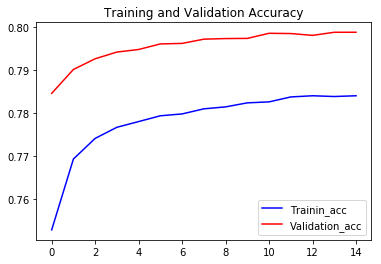

In [40]:
plt.plot(epochs,acc,label='Trainin_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

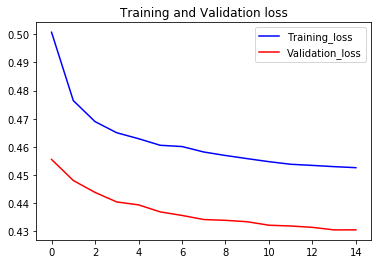

In [41]:
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

**Preprocessing of tweets given by user**

In [42]:
def preprocess(text):
    review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',text)
    review=review.lower()
    review=review.split()
    review=[word for word in review if not word in stop_words]
    print(review)
    review=pad_sequences(tokenizer.texts_to_sequences([review]), maxlen=300)
    return review

**Prediction**

In [43]:
def prediction(review):
    review=preprocess(review)
    score=model.predict(review)
    score=score[0]
    if score<0.4:
        print("Negative")
    elif score>0.4 and score<0.6:
        print("Neutral")
    else:
        print("Positive")
    print(score)


In [44]:
prediction("the food is not bad")

['food', 'not', 'bad']
Positive
[0.6509372]


In [45]:
prediction("the film was horrible")

['film', 'horrible']
Negative
[0.0633605]


In [46]:
scores = model.predict(X_test, verbose=1, batch_size=1024)

320000/320000 [==============================] - 53s 165us/step


In [47]:
scores

array([[0.00512284],
       [0.5927566 ],
       [0.75072265],
       ...,
       [0.96475744],
       [0.7788825 ],
       [0.9861531 ]], dtype=float32)

In [48]:
y_pred=np.where(scores>0.5,1,0)

In [49]:
y_pred

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [50]:
y_test

array([0, 1, 0, ..., 1, 1, 1])

**Evaluation Using Confusion Matrix, accuracy_score and classification report**

In [51]:

cm=confusion_matrix(y_pred,y_test)
print(cm)

[[128462  33017]
 [ 31584 126937]]


In [52]:
print(accuracy_score(y_pred,y_test))

0.798121875


In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80    160046
           1       0.80      0.79      0.80    159954

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



**Saving the Trained Models**

In [54]:
joblib.dump(w2v_model,'word2vec.pkl')
joblib.dump(tokenizer,'tokenizer.pkl')
joblib.dump(model,'final_model.pkl')

['final_model.pkl']

In [63]:
prediction("we'll taste success")

['taste', 'success']
Positive
[0.8788365]


In [64]:
prediction("we're all gonna die")

['gonna', 'die']
Negative
[0.05876656]


In [65]:
prediction("lets give up")

['lets', 'give']
Positive
[0.85709655]


In [66]:
prediction("dukh")

['dukh']
Neutral
[0.5697889]


In [67]:
prediction("bahut jyada dukh")

['bahut', 'jyada', 'dukh']
Neutral
[0.5697889]


In [68]:
prediction("yogesh")

['yogesh']
Neutral
[0.5697889]
